In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import os

In [17]:
from transformers import GPT2Tokenizer, GPT2Model

In [26]:
class GPT2TextEncoder(nn.Module):
    def __init__(self):
        super(GPT2TextEncoder, self).__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.model = GPT2Model.from_pretrained('gpt2')

        # Add a padding token if it doesn't exist
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            # Resize the model embeddings to accommodate the new token
            self.model.resize_token_embeddings(len(self.tokenizer))

    def forward(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

In [27]:
class Generator(nn.Module):
    def __init__(self, latent_dim, text_embedding_dim, image_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim + text_embedding_dim, 128 * (image_size // 4) * (image_size // 4))
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.conv2 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, noise, text_embeddings):
        concat_input = torch.cat((noise, text_embeddings), -1)
        x = self.fc(concat_input)
        x = self.relu(x)
        x = x.view(-1, 128, (image_size // 4), (image_size // 4))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.tanh(x)
        return x

# Step 3: Define the Discriminator Model (GAN)
class Discriminator(nn.Module):
    def __init__(self, image_size, text_embedding_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.fc = nn.Linear(128 * (image_size // 4) * (image_size // 4) + text_embedding_dim, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, text_embeddings):
        x = self.conv1(images)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = x.view(-1, 128 * (image_size // 4) * (image_size // 4))
        concat_input = torch.cat((x, text_embeddings), -1)
        x = self.fc(concat_input)
        x = self.sigmoid(x)
        return x


In [49]:
latent_dim = 100
text_embedding_dim = 768  # GPT-2 embedding size
image_size = 64
batch_size = 32
num_epochs = 1
learning_rate = 0.0002

In [50]:
text_encoder = GPT2TextEncoder()
generator = Generator(latent_dim, text_embedding_dim, image_size)
discriminator = Discriminator(image_size, text_embedding_dim)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [52]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# For simplicity, using CIFAR-10 dataset. Replace with text-image paired dataset.
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [53]:
def train(generator, discriminator, text_encoder, num_epochs, dataloader):
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            real_images = Variable(images)

            # Sample random text description
            sample_texts = ["A colorful image" for _ in range(batch_size)]  # Replace with actual text generation
            text_embeddings = text_encoder(sample_texts)

            # Labels for real and fake images
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_D.zero_grad()

            # Discriminator loss for real images
            outputs_real = discriminator(real_images, text_embeddings)
            d_loss_real = criterion(outputs_real, real_labels)

            # Discriminator loss for fake images
            noise = torch.randn(batch_size, latent_dim)
            fake_images = generator(noise, text_embeddings)
            outputs_fake = discriminator(fake_images.detach(), text_embeddings)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            # Combine real and fake loss for discriminator
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward(retain_graph=True)  # Retain graph to avoid errors
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            # Generator loss (try to fool the discriminator)
            outputs_fake = discriminator(fake_images, text_embeddings)
            g_loss = criterion(outputs_fake, real_labels)
            g_loss.backward()  # Backward pass for generator without retain_graph
            optimizer_G.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')


In [54]:
train(generator, discriminator, text_encoder, num_epochs, dataloader)

Epoch [1/1], Step [100/1563], D Loss: 0.0536, G Loss: 4.4941
Epoch [1/1], Step [200/1563], D Loss: 0.1759, G Loss: 3.0798
Epoch [1/1], Step [300/1563], D Loss: 0.3246, G Loss: 1.9281
Epoch [1/1], Step [400/1563], D Loss: 0.4188, G Loss: 2.8378
Epoch [1/1], Step [500/1563], D Loss: 0.6666, G Loss: 5.0720
Epoch [1/1], Step [600/1563], D Loss: 0.4388, G Loss: 2.9607
Epoch [1/1], Step [700/1563], D Loss: 0.2316, G Loss: 3.2334
Epoch [1/1], Step [800/1563], D Loss: 0.1986, G Loss: 2.6109
Epoch [1/1], Step [900/1563], D Loss: 0.2812, G Loss: 3.2426
Epoch [1/1], Step [1000/1563], D Loss: 0.2433, G Loss: 2.6193
Epoch [1/1], Step [1100/1563], D Loss: 0.1857, G Loss: 3.5141
Epoch [1/1], Step [1200/1563], D Loss: 0.2709, G Loss: 2.5554
Epoch [1/1], Step [1300/1563], D Loss: 0.0924, G Loss: 4.1143
Epoch [1/1], Step [1400/1563], D Loss: 0.2935, G Loss: 2.4230
Epoch [1/1], Step [1500/1563], D Loss: 0.4032, G Loss: 3.1465


In [57]:
def generate_image(generator, text_encoder, text_description):
    generator.eval()
    text_embedding = text_encoder([text_description])
    noise = torch.randn(1, latent_dim)
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).cpu()
    generated_image = generated_image * 0.5 + 0.5  # Denormalize
    np_image = np.transpose(generated_image.squeeze(0).numpy(), (1, 2, 0))
    plt.imshow(np_image)
    plt.title(f"Generated Image: {text_description}")
    plt.axis('off')
    plt.show()

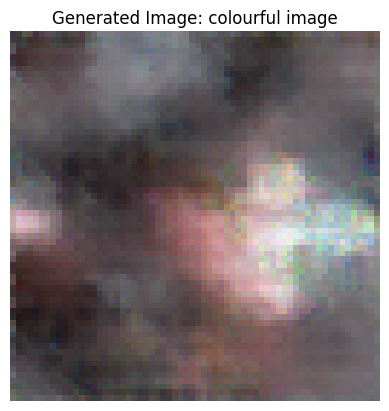

In [62]:
generate_image(generator, text_encoder, "colourful image")